## Name entity recognition 

# Author: Hok Seng

<p>
    <b>Notebook Sections</b><br>
    This notebook is divided into the following sections:
    <ul>
        <li>A. Setting Environment</li>
        <li>B. Set the Devic (cpu or mps) </li>
    </ul>
</p>

In [1]:
import os
import subprocess
import requests

os.getcwd()

'/Users/senghok/Documents/Internship 2A/code'

## Download necessary packages

In [ ]:
with open("requirement.txt", "r") as file:
    for f in file.readlines():
        package = f.strip()
        if package:
            subprocess.check_call(["pip", "install", package])
            %pip install {package}

## Import necessary packages

In [18]:


save_dir = "data"
os.makedirs(save_dir,exist_ok = True)

file_name = os.path.join(save_dir,"NER_dataset.csv")

response = requests.get(url,stream = True)


if response.status_code == 200:
    with open(file_name,"wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"File downloaded successfully and saved to {file_name}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")



File downloaded successfully and saved to data/NER_dataset.csv


In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
import seaborn as sns
import collections
from itertools import chain
import random
import copy
import itertools
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW

from transformers import BertTokenizer
from transformers import BertForTokenClassification
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns



# set the option to display all columns
pd.set_option('display.max_columns', None)

/Users/senghok/Documents/Internship 2A/code/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/senghok/Documents/Internship 2A/code/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.l

In [2]:
path = "./data/NER_dataset.csv"
data = pd.read_csv(path, encoding = 'unicode_escape')

In [3]:
data.shape

(1048575, 4)

## Preprocessing Data

### 1. Replacing the NaN values by 'Sentence #'

In [4]:
data.loc[:,"Sentence #"] = data.loc[:,"Sentence #"].ffill()

### 1.1 Check the shape

In [5]:
print(f"Number of rows: {data.shape[0]}\n"
      f"Number of columns: {data.shape[1]}")

Number of rows: 1048575
Number of columns: 4


### 2. Drop the unwanted 'POS' column

In [6]:
data.drop(columns= ['POS'],inplace = True)

In [7]:
data.head(3)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O


In [8]:
data.shape[0] #including some eventual NaN data

1048575

### Remove rows that have NaN value

In [9]:
data.dropna(inplace = True)
print(f"Number of updated data: {data.shape[0]}")

Number of updated data: 1048565


### 2.1 Verify the missing values

In [10]:
tag_null_mask = data[['Tag']].isnull().any(axis=1)
tag_null_rows = data[tag_null_mask]
print(f"number of rows where tag is NaN: {tag_null_rows.size}")

number of rows where tag is NaN: 0


In [11]:
word_null_mask = data[['Word']].isnull().any(axis=1)
word_null_rows = data[word_null_mask]
print(f"number of rows where word is NaN: {word_null_rows.size}")

number of rows where word is NaN: 0


In [12]:
print(data.columns.tolist())

['Sentence #', 'Word', 'Tag']


In [13]:
# class SentenceGetter(object):
    
#     def __init__(self, dataset, word_col, tag_col, sent_id_col):
#         self.n_sent = 1
#         self.dataset = dataset
#         self.empty = False
#         agg_func = lambda s: [
#             (w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())
#         ]
#         self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
#         self.sentences = [s for s in self.grouped]
    
#     def get_next(self):
#         try:
#             s = self.grouped["Sentence: {}".format(self.n_sent)]
#             self.n_sent += 1
#             return s
#         except:
#             return None
        
# getter = SentenceGetter(dataset=data, word_col='Word', tag_col='Tag', sent_id_col='Sentence #')
# sentences = getter.sentences
# print(sentences[0])


# fig, ax = plt.subplots(figsize=(20, 6))
# ax.hist([len(s) for s in sentences], bins=50)
# ax.set_title('Number of words in each Sentence')

# maxlen = max([len(s) for s in sentences])
# print('Number of Sentences:', len(sentences))
# print ('Maximum sequence length:', maxlen)

# words = list(set(data["Word"].values))
# words.append("ENDPAD")
# n_words = len(words)
# print('Number of unique words:', n_words)


# # Find and print the first sentence with that length
# longest_sentence = [s for s in sentences if len(s) == maxlen][0]

# print("Longest sentence (word-tag pairs):")
# print(len(longest_sentence))


### 3. Checking impropers Words

### 3.1 Helper Function

In [14]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)


def is_escaped_unicode(_str):
    if is_ascii(_str):
        return True
    return False


def is_proper_word(_word):
    if not is_escaped_unicode(_word):
        if isinstance(_word,str) and len(_word) < 3:
            return False
    return True

In [15]:
data['is_proper_word'] = data['Word'].apply(is_proper_word)

In [16]:
data[["Sentence #","Word"]].iloc[56462]

Sentence #    Sentence: 2556
Word                      °C
Name: 56462, dtype: object

In [17]:
display(data[~data['is_proper_word']])

,Sentence #,Word,Tag,is_proper_word
1786,Sentence: 77,,O,False
56462,Sentence: 2556,°C,O,False
124883,Sentence: 5700,s,O,False
124903,Sentence: 5700,s,O,False
181958,Sentence: 8332,,I-tim,False
199965,Sentence: 9159,,O,False
199968,Sentence: 9159,,O,False
219475,Sentence: 10052,,O,False
219476,Sentence: 10052,,O,False
219486,Sentence: 10052,,O,False


### Retain only the data where appear only proper words

In [18]:
data = data[data['is_proper_word']]

In [19]:
data.drop(columns = ["is_proper_word"], inplace = True)
print(f"Updated cols of the data: {data.columns.tolist()}")
print(f"Updated number of rows: {data.shape[0]}")

Updated cols of the data: ['Sentence #', 'Word', 'Tag']
Updated number of rows: 1048534


### Frequency of each tag
Compute the frequency of each tag

In [20]:
print(f"Number of tags: {len(data.Tag.unique())}")
frequencies = data.Tag.value_counts()
display(frequencies)

Number of tags: 17


Tag
O        887870
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16782
B-gpe     15870
I-geo      7414
I-tim      6527
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [21]:
for i in frequencies.index:
    print(i)

O
B-geo
B-tim
B-org
I-per
B-per
I-org
B-gpe
I-geo
I-tim
B-art
B-eve
I-art
I-eve
B-nat
I-gpe
I-nat


In [22]:
## count the frequencies of sub-tags in decreasing order

# Dict for storing the tags and their frequency
tags = {}

# iterate through each tag
for tag, count in zip(frequencies.index, frequencies):
    # Check if the tag is not 'O'
    if tag != "O":
        # extract the sub-tag 
        if tag[2:5] not in tags.keys():
            # create a key with its count
            tags[tag[2:5]] = count
        else:
            # if sub-tag already exists, then simply update the count
            tags[tag[2:5]] += count

# print the sub-tags in sorted order
print(sorted(tags.items(), key=lambda x: x[1], reverse=True))


[('geo', 45058), ('org', 36925), ('per', 34241), ('tim', 26860), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


### Dealing with tags that could act as Noise

In [23]:
labels_to_remove =[]
for index in frequencies.index:
    if frequencies[index] < 1000:
        labels_to_remove.append(index)
        
labels_to_remove

['B-art', 'B-eve', 'I-art', 'I-eve', 'B-nat', 'I-gpe', 'I-nat']

In [24]:
# Convert the rare tags to "O"

data.loc[data['Tag'].isin(labels_to_remove), "Tag"] ='O'

### 4. Compute label Maps

In [25]:
label2id = {k: v for v,k in enumerate(data.Tag.unique())}
id2label = {v: k for v,k in enumerate(data.Tag.unique())}

label2id.keys()

dict_keys(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'I-per', 'I-tim'])

In [26]:
data.head(4)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O


### 5. Create complete sentences with their labels as one string

In [27]:
# let's create a new column called "sentence" which groups the words by sentence 
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence 
data['labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,Tag,sentence,labels
0,Sentence: 1,Thousands,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Sentence: 1,of,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
3,Sentence: 1,have,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
4,Sentence: 1,marched,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."


In [28]:
data = data[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."


### 6. Remove the sentences that contain only "O" tags and don't contain any other target labels

In [29]:
# # Group by sentence
# grouped = data.groupby('Sentence #')

# # Find sentence indices where all tags are 'O'
# drop_sentence_ids = []
# for sent_id, group in grouped:
#     if set(group['Tag']) == {'O'}:
#         drop_sentence_ids.append(sent_id)

# # Drop all such sentences at once
# data = data[~data['Sentence #'].isin(drop_sentence_ids)]

# print(f"Total number of removed sentences that contain only 'O' tags: {len(drop_sentence_ids)}")


In [30]:
# print(f"Total number of sentences after removing sentences containing all 'O' labels: {len(data)}")

In [31]:
# data['num_words'] = data['sentence'].apply(lambda x: len(x.split(' ')))
# data

In [32]:
# data['num_labels'] = data['labels'].apply(lambda x: len(x.split(',')))
# data

In [33]:
# def simple_tokenizer(text):
#     return text.lower().split()


In [34]:
# # Apply tokenizer to create 'tokens' column
# data['tokens'] = data['sentence'].apply(word_tokenize)

In [35]:
# data['num_tokens'] = data['tokens'].apply(len)  #number of tokens
# data.head()

In [36]:
# data['words_tokens_diff'] = data['num_tokens'] - data['num_words']

In [37]:
# data[data['words_tokens_diff']==1]

In [38]:
# data['words_labels_diff'] = data['num_words'] - data['num_labels']

In [39]:
# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.figure(figsize=(24, 24))
# plt.rcParams["figure.figsize"] = (10,5)

# words_labels_diff = data['words_labels_diff'].values.tolist()

# min_words_labels_diff = min(words_labels_diff)
# max_words_labels_diff = max(words_labels_diff)
# median_words_labels_diff = int(np.median(words_labels_diff))

# # Plot the distribution of comment lengths.
# sns.displot(words_labels_diff, kde=False, rug=False,color='green')

# plt.title('Difference in # of Words and # of Labels')
# plt.xlabel('Difference')
# plt.ylabel('# of Sentences')
# plt.savefig('./images/words_labels_diff.png', bbox_inches='tight', dpi=300)
# plt.show()


# print("\nStats for length of Tokens")
# print(f"Minimum difference in num of words and num of labels: {min_words_labels_diff}") 
# print(f"Maximum difference in num of words and num of labels: {max_words_labels_diff}") 
# print(f"Median difference in num of words and num of labels: {median_words_labels_diff}")

In [40]:
# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.figure(figsize=(24, 24))
# plt.rcParams["figure.figsize"] = (10,5)

# token_lens = data['num_tokens'].values.tolist()

# min_token_len = min(token_lens)
# max_token_len = max(token_lens)
# median_token_len = int(np.median(token_lens))

# # Plot the distribution of comment lengths.
# sns.displot(token_lens, kde=False, rug=False,color='green')

# plt.title('Tokens Lengths')
# plt.xlabel('Tokens Length (# of tokens)')
# plt.ylabel('# of Sentences')
# plt.savefig('./images/bert_tokens_lengths.png')
# plt.show()

# print("\nStats for length of Bert Tokens")
# print(f"Minimum Tokens length: {min_token_len}") 
# print(f"Maximum Tokens length: {max_token_len}") 
# print(f"Median Tokens length: {median_token_len}")


In [41]:
# data['words_tokens_diff'].value_counts()

In [42]:
# words_tokens_diff = data['words_tokens_diff'].values.tolist()
# count = Counter(words_tokens_diff)
# count

In [43]:
# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.figure(figsize=(24, 24))
# plt.rcParams["figure.figsize"] = (10,10)

# words_tokens_diff = data['words_tokens_diff'].values.tolist()

# min_words_tokens_diff = min(words_tokens_diff)
# max_words_tokens_diff = max(words_tokens_diff)
# median_words_tokens_diff = int(np.median(words_tokens_diff))

# # Plot the distribution of comment lengths.
# sns.displot(words_tokens_diff, kde=False, rug=False,color='blue')

# plt.title('Difference in Length ')
# plt.xlabel('Difference')
# plt.ylabel('# of Sentences')
# plt.savefig('./images/words_tokens_diff.png', bbox_inches='tight')
# plt.show()

# print("\nStats for length difference between Bert Tokens and sentence length")
# print(f"Minimum difference in num of tokens and num of words: {min_words_tokens_diff}") 
# print(f"Maximum difference in num of tokens and num of words: {max_words_tokens_diff}") 
# print(f"Median difference in num of tokens and num of words: {median_words_tokens_diff}")


### 14. Setting meaningfull Max Len

### 14.1.a. threshold = 78

In [44]:
# len_thresh = 78
# data[data['num_tokens'] == 104]

In [45]:
# data = data[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)
# display(data.head())
# print(f"\n Nnumber of sentences in clean dataframe: {len(data)}")

### Explore distribution of Labels

In [46]:
# bal_df = pd.DataFrame(columns= ['s_id', 'labels'])

In [47]:
# bal_df

In [48]:
# test = pd.DataFrame(data = {"s_id":[1,2,3], "name":["A","B","C"]})
# test

In [49]:
# test = pd.get_dummies(test)

In [50]:
# # split the labels column of data into list of labels
# bal_df['labels'] = data['labels'].apply(lambda x: x.split(','))
# # set 's_id' column to be the index column of data 
# bal_df['s_id'] = data.index

# # display the bal df
# display(bal_df.head())

In [51]:
# bal_df = bal_df.explode('labels')
# display(bal_df.head())


### Create the dummies for labels column

In [52]:
# bal_df = pd.get_dummies(bal_df)
# display(bal_df.head())

In [53]:
# bal_df.shape[0]

### Count the frequency of each label for every sentence

In [54]:
# bal_df = bal_df.groupby(['s_id'],as_index=True).sum()
# display(bal_df.head())

In [55]:
# # get the descriptive statistics of each label
# bal_df.describe()

### 7. Plot the kernel density plots for each label

In [56]:
# # set the figure dimensions and labels, label size and title
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.yaxis.set_tick_params(labelsize = 8)
# ax.xaxis.set_tick_params(labelsize = 8)
# ax.set(xlabel='Count', ylabel='Labels', title='Violin Plot')
# # build the plot
# g = sns.violinplot(data=bal_df.loc[:, bal_df.columns != 'labels_O'], linewidth=1, inner="quart", orient='h')
# # show the plot
# plt.savefig('./images/labels_violin_plot.png', bbox_inches='tight')
# plt.show()


### Frequency of each labels

In [57]:
# # count the frequency of each label in ascending order
# labels_counts = bal_df.sum(axis = 0).sort_values(ascending= True)
# labels_counts.values

### Plot frequency of each label

In [58]:
# fig, ax = plt.subplots(figsize=(6, 4))
# ax.yaxis.set_tick_params(labelsize = 8)
# ax.xaxis.set_tick_params(labelsize =8)
# plt.xticks(rotation=45)
# g = sns.barplot(x=labels_counts.index, y=labels_counts.values, ax=ax)
# ax.set(xlabel='label', ylabel='frequency', title='Labels Frequency')
# ax.bar_label(ax.containers[0], fontsize=8)
# plt.savefig('./images/labels_freq.png', bbox_inches='tight')
# plt.show()

# #fig.savefig('n_label_freq.png', bbox_inches='tight', dpi=1600)

### Helper Functions to Create Balanced Split function

In [59]:
label2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-tim': 9}

In [60]:
# create multilabel binarizer
mlb = MultiLabelBinarizer(classes=list(label2id.keys()))
mlb

,classes,"['O', 'B-geo', ...]"
,sparse_output,False


In [61]:
test_data = data.copy()
test_data.shape

(47607, 2)

In [62]:

ind = np.expand_dims(np.arange(len(test_data)), axis=1)
unique_sentence = test_data['labels'].apply(lambda x: set(itertools.chain.from_iterable([x.split(',')])))

### Splitting

Method: we use multilabel splitting method from library skmultilearn.model_selection as it can split the data evenly with balanced distribution of different label between the test and the train set

In [63]:

# Function to create stratified split
def balanced_split(df, mlb, test_size):
    ind_ = np.expand_dims(np.arange(len(df)), axis=1)
    # series of unique labels
    unique_labels_ = df['labels'].apply(lambda x: set(itertools.chain.from_iterable([x.split(',')])))
    labels_ohe_ = mlb.fit_transform(unique_labels_)
    ind_train, _, ind_test, _ = iterative_train_test_split(
        ind_, labels_ohe_, test_size
    )
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]



### Another way is to use tf.keras.preprocessing.text_dataset_from_directory

### All data - Seen Data(80%) + Unseen/Test Data(20%)

In [64]:
seen_df, test_df = balanced_split(data, mlb, test_size=0.2)

In [65]:
print(f"Full Dataset size: {len(data)}")
print(f"Seen Dataset size: {len(seen_df)}")
print(f"Test Data Size: {len(test_df)}")

Full Dataset size: 47607
Seen Dataset size: 38087
Test Data Size: 9520


### Seen Data - Trainning Data(90%) + Validation Data(10%)

In [66]:
train_df, valid_df = balanced_split(seen_df, mlb, test_size=0.1)

In [67]:
print(f"Seen Dataset size: {len(seen_df)}")
print(f"Train Dataset size: {len(train_df)}")
print(f"Valid Data Size: {len(valid_df)}")

Seen Dataset size: 38087
Train Dataset size: 34279
Valid Data Size: 3808


In [68]:
# check the size of each data
print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALID Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

FULL Dataset: (47607, 2)
TRAIN Dataset: (34279, 2)
VALID Dataset: (3808, 2)
TEST Dataset: (9520, 2)


In [69]:
train_df["labels"].iloc[3]

'O,B-org,I-org,O,O,B-gpe,O,O,O,O,O,O,B-gpe,O,O,B-org,I-org,I-org,O,O,O,O,O,O,O,O,B-gpe,O,O,O,O,O,O,O'

In [70]:
train_df["sentence"].iloc[3]

'The European Union , with U.S. backing , has threatened to refer Iran to the U.N. Security Council , which could impose sanctions if it finds Tehran has violated the Nuclear Non-Proliferation treaty .'

In [71]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [72]:
train_df.head(3)

,sentence,labels
0,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
1,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-..."


In [73]:
# Step 1: Get a set of all labels used in the dataset
all_labels = set(itertools.chain.from_iterable(train_df['labels'].apply(lambda x: x.split(','))))
all_labels

{'B-geo',
 'B-gpe',
 'B-org',
 'B-per',
 'B-tim',
 'I-geo',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

### One hot encoding for all the labels in training , validation and testing dataset

In [74]:

# Step 2: Initialize the MultiLabelBinarizer with all known classes
mlb = MultiLabelBinarizer(classes=sorted(all_labels))

# Step 3: Transform per-sentence label sets
unique_train_labels_ohe = mlb.fit_transform(
    train_df['labels'].apply(lambda x: set(x.split(',')))
)


In [75]:
unique_train_labels_ohe.shape

(34279, 10)

In [76]:


# Validation
unique_valid_labels_ohe = mlb.transform(
    valid_df['labels'].apply(lambda x: set(x.split(',')))
)

# Testing
unique_test_labels_ohe = mlb.transform(
    test_df['labels'].apply(lambda x: set(x.split(',')))
)


In [77]:
# compute number of samples
num_train_samples = unique_train_labels_ohe.shape[0]
num_valid_samples = unique_valid_labels_ohe.shape[0]
num_test_samples = unique_test_labels_ohe.shape[0]

# compute number of samples for each unique label
train_labels_count = unique_train_labels_ohe.sum(axis=0)
valid_labels_count = unique_valid_labels_ohe.sum(axis=0)
test_labels_count = unique_test_labels_ohe.sum(axis=0)

# compute proportion of samples for each unique label
prop_train_labels = train_labels_count/num_train_samples
prop_valid_labels = valid_labels_count/num_valid_samples
prop_test_labels = test_labels_count/num_test_samples


print("Training Data")
print("==============")
print(f"Total num of training samples: {num_train_samples}")
print(f"Total num of each label: {train_labels_count}")
print(f"Proportions of each label: {prop_train_labels}\n")

print("Validation Data")
print("==============")
print(f"Total num of validation samples: {num_valid_samples}")
print(f"Total num of each label: {valid_labels_count}")
print(f"Proportions of each label: {prop_valid_labels}\n")

print("Testing Data")
print("===============")
print(f"Total num of training samples: {num_test_samples}")
print(f"Total num of each label: {test_labels_count}")
print(f"Proportions of each label: {prop_test_labels}")

Training Data
Total num of training samples: 34279
Total num of each label: [17483  9207 11288  9674 12369  4313  6124  7614  3094 34273]
Proportions of each label: [0.51002071 0.2685901  0.32929782 0.2822136  0.36083316 0.12582047
 0.17865165 0.2221185  0.09025934 0.99982497]

Validation Data
Total num of validation samples: 3808
Total num of each label: [1943 1023 1254 1074 1374  492  642  855  304 3808]
Proportions of each label: [0.5102416  0.26864496 0.32930672 0.28203782 0.36081933 0.12920168
 0.16859244 0.22452731 0.07983193 1.        ]

Testing Data
Total num of training samples: 9520
Total num of each label: [4857 2558 3135 2685 3436 1210 1683 2124  834 9520]
Proportions of each label: [0.51018908 0.26869748 0.32930672 0.28203782 0.36092437 0.12710084
 0.17678571 0.22310924 0.08760504 1.        ]


### Create the proportion dataFrame for training, validation and testing data

In [78]:
# create dict for proportions of each label
prop_data = {
    'labels' : list(label2id.keys()),
    'train' : prop_train_labels,
    'valid' : prop_valid_labels,
    'test' : prop_test_labels
}

# create dataframe
prop_df = pd.DataFrame.from_dict(prop_data)

# display
display(prop_df)

,labels,train,valid,test
0,O,0.510021,0.510242,0.510189
1,B-geo,0.268590,0.268645,0.268697
2,B-gpe,0.329298,0.329307,0.329307
3,B-per,0.282214,0.282038,0.282038
4,I-geo,0.360833,0.360819,0.360924
5,B-org,0.125820,0.129202,0.127101
6,I-org,0.178652,0.168592,0.176786
7,B-tim,0.222118,0.224527,0.223109
8,I-per,0.090259,0.079832,0.087605
9,I-tim,0.999825,1.000000,1.000000


In [79]:
# fig, ax = plt.subplots(figsize=(10, 8))
# g = sns.barplot(
#     data=prop_df.melt(id_vars = ["labels"], value_vars=["train", "valid", "test"]),
#     y="value", x="variable", hue="labels", errorbar=None
# )

# # for legend text
# plt.setp(g.get_legend().get_texts(), fontsize='10')  
 
# # for legend title
# plt.setp(g.get_legend().get_title(), fontsize='10')
# plt.title("Proportions of sentences containing each label - training, validation and testing dataset")
# plt.savefig('./images/label_proportions.png', bbox_inches='tight', dpi=300)
# plt.show()

### Check distributions of 2nd order

In [80]:
# from collections import Counter
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

# label_combination_df = pd.DataFrame({
#     'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=2) for combination in row),
#     'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=2) for combination in row),
#     'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(unique_test_labels_ohe, order=2) for combination in row),
# }).T.fillna(0.0).astype('float')

# # compute proportions
# label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
# label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples
# label_combination_df.loc['test'] = label_combination_df.loc['test']/num_test_samples

# label_combination_df

In [81]:
# from collections import Counter
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

# label_combination_df = pd.DataFrame({
#     'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=3) for combination in row),
#     'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=3) for combination in row),
#     'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(unique_test_labels_ohe, order=3) for combination in row),
# }).T.fillna(0.0).astype('float')

# # compute proportions
# label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
# label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples
# label_combination_df.loc['test'] = label_combination_df.loc['test']/num_test_samples

# label_combination_df

### Baseline model
### RNN + Softmax

In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense

### Tokenization
### Word tokenization

In [83]:
# Tokenize sentences (whitespace)
def tokenize(sentence):
    return sentence.strip().split()
# Split labels
def split_labels(label_str):
    return label_str.strip().split(',')


In [84]:

train_df['tokens'] = train_df['sentence'].apply(tokenize)
train_df['label_list'] = train_df['labels'].apply(split_labels)

In [85]:
train_df[train_df["tokens"].apply(len) >50]



,sentence,labels,tokens,label_list
600,The visit by Assistant Secretary of State for ...,"O,O,O,O,O,O,B-org,I-org,I-org,I-org,I-org,I-or...","[The, visit, by, Assistant, Secretary, of, Sta...","[O, O, O, O, O, O, B-org, I-org, I-org, I-org,..."
634,Strong performances in construction and manufa...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,...","[Strong, performances, in, construction, and, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
803,After failing in the Korean War ( 1950 - 53 ) ...,"O,O,O,O,O,O,O,B-tim,I-tim,I-tim,O,O,O,O,B-geo,...","[After, failing, in, the, Korean, War, (, 1950...","[O, O, O, O, O, O, O, B-tim, I-tim, I-tim, O, ..."
1140,"Former U.S. Marine General John J. "" Jack "" Sh...","O,B-org,I-org,I-org,B-per,I-per,I-per,I-per,I-...","[Former, U.S., Marine, General, John, J., "", J...","[O, B-org, I-org, I-org, B-per, I-per, I-per, ..."
4331,But the Honest Man explained that as he was me...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,...","[But, the, Honest, Man, explained, that, as, h...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...
30696,Mourners and officials of the Socialist Party ...,"O,O,O,O,O,B-org,I-org,O,O,B-per,O,O,O,O,O,O,O,...","[Mourners, and, officials, of, the, Socialist,...","[O, O, O, O, O, B-org, I-org, O, O, B-per, O, ..."
30796,In an interview broadcast Sunday on U.S. telev...,"O,O,O,O,B-tim,O,B-geo,O,O,O,B-org,O,O,O,O,O,B-...","[In, an, interview, broadcast, Sunday, on, U.S...","[O, O, O, O, B-tim, O, B-geo, O, O, O, B-org, ..."
32287,Following its heyday as a global maritime powe...,"O,O,O,O,O,O,O,O,O,O,B-tim,I-tim,I-tim,O,O,B-pe...","[Following, its, heyday, as, a, global, mariti...","[O, O, O, O, O, O, O, O, O, O, B-tim, I-tim, I..."
32874,"Renewed activity in the mining sector , the so...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,O,O,O,...","[Renewed, activity, in, the, mining, sector, ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


### ID tokenization

### We can use Text vectorization

# Text vectorization consiste of parts:
<li>
    Standardization
</li>
<li>
    Tokenization
</li>
<li>
    Vocabulary building
</li>

### Vocabulary

In [86]:
word_counts = Counter(word for tokens in train_df['tokens'] for word in tokens)
word2id = {word: i + 2 for i, word in enumerate(word_counts)} # turn words into unique ids (+2) because give 0,1 to UNK and PAD

In [87]:
word2id  ## vocabulary

{'Families': 2,
 'of': 3,
 'soldiers': 4,
 'killed': 5,
 'in': 6,
 'the': 7,
 'conflict': 8,
 'joined': 9,
 'protesters': 10,
 'who': 11,
 'carried': 12,
 'banners': 13,
 'with': 14,
 'such': 15,
 'slogans': 16,
 'as': 17,
 '"': 18,
 'Bush': 19,
 'Number': 20,
 'One': 21,
 'Terrorist': 22,
 'and': 23,
 'Stop': 24,
 'Bombings': 25,
 '.': 26,
 'Police': 27,
 'put': 28,
 'number': 29,
 'marchers': 30,
 'at': 31,
 '10,000': 32,
 'while': 33,
 'organizers': 34,
 'claimed': 35,
 'it': 36,
 'was': 37,
 '1,00,000': 38,
 'The': 39,
 'party': 40,
 'is': 41,
 'divided': 42,
 'over': 43,
 'Britain': 44,
 "'s": 45,
 'participation': 46,
 'Iraq': 47,
 'continued': 48,
 'deployment': 49,
 '8,500': 50,
 'British': 51,
 'troops': 52,
 'that': 53,
 'country': 54,
 'European': 55,
 'Union': 56,
 ',': 57,
 'U.S.': 58,
 'backing': 59,
 'has': 60,
 'threatened': 61,
 'to': 62,
 'refer': 63,
 'Iran': 64,
 'U.N.': 65,
 'Security': 66,
 'Council': 67,
 'which': 68,
 'could': 69,
 'impose': 70,
 'sanctions': 71

In [88]:
word2id['<PAD>'] = 0
word2id['<UNK>'] = 1

In [89]:
word2id['<UNK>']

1

In [90]:
word2id['<PAD>'], word2id['<UNK>']

(0, 1)

In [91]:
# Build vocab for labels
label_set = set(label for labels in train_df['label_list'] for label in labels)
label2id = {label: i for i, label in enumerate(sorted(label_set))}
id2label = {i: label for label, i in label2id.items()}

In [92]:
label2id

{'B-geo': 0,
 'B-gpe': 1,
 'B-org': 2,
 'B-per': 3,
 'B-tim': 4,
 'I-geo': 5,
 'I-org': 6,
 'I-per': 7,
 'I-tim': 8,
 'O': 9}

In [93]:
fallback = '<UNK>'
fallback_id = word2id.get('B-gpe', list(label2id.values())[0])  ## get idea of a word

fallback_id

0

In [94]:
label2id

{'B-geo': 0,
 'B-gpe': 1,
 'B-org': 2,
 'B-per': 3,
 'B-tim': 4,
 'I-geo': 5,
 'I-org': 6,
 'I-per': 7,
 'I-tim': 8,
 'O': 9}

In [95]:
pad_token = '<PAD>'
pad_id = label2id.get(pad_token, list(label2id.values())[0])  
pad_id

0

In [96]:
fallback_id = label2id.get('O', list(label2id.values())[0])
fallback_id

9

In [97]:
MAX_LEN = 40

# encoding X: 
# Post padding
# Padding and Truncation
def encode(tokens, vocab, pad_len=MAX_LEN, fallback='<UNK>', pad_token='<PAD>'):
    fallback_id = vocab.get(fallback, list(vocab.values())[0])  # fallback to 0 if not found (1)
    pad_id = vocab.get(pad_token, list(vocab.values())[0])    # fallback to 0 if not found (0)
    ids = [vocab.get(tok, fallback_id) for tok in tokens]
    return ids[:pad_len] + [pad_id] * max(0, pad_len - len(ids))


In [98]:
X = np.array([encode(tokens, word2id, fallback='<UNK>', pad_token='<PAD>') for tokens in train_df['tokens']])
y = np.array([encode(labels, label2id, fallback='O', pad_token='O') for labels in train_df['label_list']])
vocab_size = len(word2id)
label_size = len(label2id)


In [99]:
## Example:
sentence = train_df['tokens'][600]
label    = train_df['label_list'][600]
encoded_sentence = encode(sentence,word2id,fallback= '<UNK>', pad_token = '<PAD>')
encoded_label  = encode(label, label2id, fallback = 'O', pad_token = 'O')
print(f"Sentence : {sentence} with length {len(sentence)}\n",
       f"encoded sentence : {encoded_sentence} with length {len(encoded_sentence)}\n")

print(f"Label : {label} with length {len(label)}\n",
       f"encoded label : {encoded_label} with length {len(encoded_label)}")

Sentence : ['The', 'visit', 'by', 'Assistant', 'Secretary', 'of', 'State', 'for', 'African', 'Affairs', 'Connie', 'Newman', 'and', 'special', 'envoy', 'for', 'Sudan', 'Roger', 'Winter', 'follows', 'two', 'days', 'of', 'riots', 'in', 'response', 'to', 'news', 'of', 'the', 'death', 'of', 'Mr.', 'Garang', ',', 'the', 'former', 'rebel', 'leader', 'who', 'became', 'Sudan', "'s", 'vice', 'president', 'as', 'part', 'of', 'a', 'peace', 'deal', '.'] with length 52
 encoded sentence : [39, 1131, 87, 3588, 3589, 3, 639, 141, 328, 2502, 3590, 3591, 23, 2271, 3592, 141, 954, 2113, 3593, 3594, 386, 1694, 3, 3595, 6, 1890, 62, 645, 3, 7, 421, 3, 320, 2760, 57, 7, 1002, 334, 1114, 11] with length 40

Label : ['O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'B-gpe', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [100]:

id2word = {v:k for k,v in word2id.items()}
# Decode the sentence
decoded_sentence = [id2word.get(word_id, '<UNK>') for word_id in encoded_sentence]
decoded_sentence

['The',
 'visit',
 'by',
 'Assistant',
 'Secretary',
 'of',
 'State',
 'for',
 'African',
 'Affairs',
 'Connie',
 'Newman',
 'and',
 'special',
 'envoy',
 'for',
 'Sudan',
 'Roger',
 'Winter',
 'follows',
 'two',
 'days',
 'of',
 'riots',
 'in',
 'response',
 'to',
 'news',
 'of',
 'the',
 'death',
 'of',
 'Mr.',
 'Garang',
 ',',
 'the',
 'former',
 'rebel',
 'leader',
 'who']

In [101]:
## Convert to sentence with masked entity
sentence_masked = []
for index, lab in enumerate(label):
    if lab == 'O':
        sentence_masked.append(sentence[index])
    else:
        sentence_masked.append(label[index])
sentence_masked       

['The',
 'visit',
 'by',
 'Assistant',
 'Secretary',
 'of',
 'B-org',
 'I-org',
 'I-org',
 'I-org',
 'I-org',
 'I-org',
 'and',
 'special',
 'envoy',
 'for',
 'B-gpe',
 'B-per',
 'I-per',
 'follows',
 'two',
 'days',
 'of',
 'riots',
 'in',
 'response',
 'to',
 'news',
 'of',
 'the',
 'death',
 'of',
 'B-per',
 'I-per',
 ',',
 'the',
 'former',
 'rebel',
 'leader',
 'who',
 'became',
 'B-gpe',
 "'s",
 'vice',
 'president',
 'as',
 'part',
 'of',
 'a',
 'peace',
 'deal',
 '.']

In [102]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (34279, 40), y shape: (34279, 40)


In [103]:
vocab_size,label_size

(30517, 10)

In [104]:
valid_df

,sentence,labels
0,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
1,The International Atomic Energy Agency is to h...,"O,B-org,I-org,I-org,I-org,O,O,O,O,O,O,O,O,B-ge..."
2,The German firm works as a sub-contractor for ...,"O,B-gpe,O,O,O,O,O,O,B-org,O"
3,Militant groups frequently attack oil operatio...,"O,O,O,O,O,O,O,O,B-geo,I-geo,O,O,O,O,O,O,O,O,O,..."
4,The attacks occurred after the government said...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-gpe,..."
...,...,...
3803,The Nobel committee says their research goes f...,"O,B-org,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
3804,The price of a barrel of oil for future delive...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
3805,Kabul has ruled out a prisoner swap .,"B-org,O,O,O,O,O,O,O"
3806,"On Sunday , authorities sealed the campus of H...","O,B-tim,O,O,O,O,O,O,B-org,I-org,O,O,O,O,O,O,O,O,O"


In [105]:
# Tokenize sentences and split labels
for df in [valid_df, test_df]:
    df['tokens'] = df['sentence'].apply(lambda x: x.strip().split())
    df['label_list'] = df['labels'].apply(lambda x: x.strip().split(','))
X_valid = np.array([
    encode(tokens, word2id, fallback='<UNK>', pad_token='<PAD>')
    for tokens in valid_df['tokens']
])

y_valid = np.array([
    encode(labels, label2id, fallback='O', pad_token='O')
    for labels in valid_df['label_list']
])


X_test = np.array([
    encode(tokens, word2id, fallback='<UNK>', pad_token='<PAD>')
    for tokens in test_df['tokens']
])
y_test = np.array([
    encode(labels, label2id, fallback='O', pad_token='O')
    for labels in test_df['label_list']
])


In [106]:
print(f"Shape of Training Data (X, y): {X.shape}, {y.shape}")
print(f"Shape of Validation Data (X_valid, y_valid): {X_valid.shape}, {y_valid.shape}")
print(f"Shape of Test Data (X_test, y_test): {X_test.shape}, {y_test.shape}")

Shape of Training Data (X, y): (34279, 40), (34279, 40)
Shape of Validation Data (X_valid, y_valid): (3808, 40), (3808, 40)
Shape of Test Data (X_test, y_test): (9520, 40), (9520, 40)


In [107]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [108]:
# [
#     Embedding(input_dim=vocab_size, output_dim=64, input_length=MAX_LEN),
#     Bidirectional(LSTM(units=64, return_sequences=True)),
#     TimeDistributed(Dense(label_size, activation='softmax'))
# ]
input = Input(shape = (MAX_LEN,))
x = Embedding(input_dim= vocab_size,output_dim = 64)(input)
x = LSTM(128, return_sequences=True)(x)
x = TimeDistributed(Dense(64, activation='relu'))(x)
x = TimeDistributed(Dense(label_size, activation='softmax'))(x)

model = Model(inputs= input,outputs=x)


In [109]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 40, 64)         │     1,953,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 40, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 10)         │           650 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,060,810 (7.86 MB)

 Trainable params: 2,060,810 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

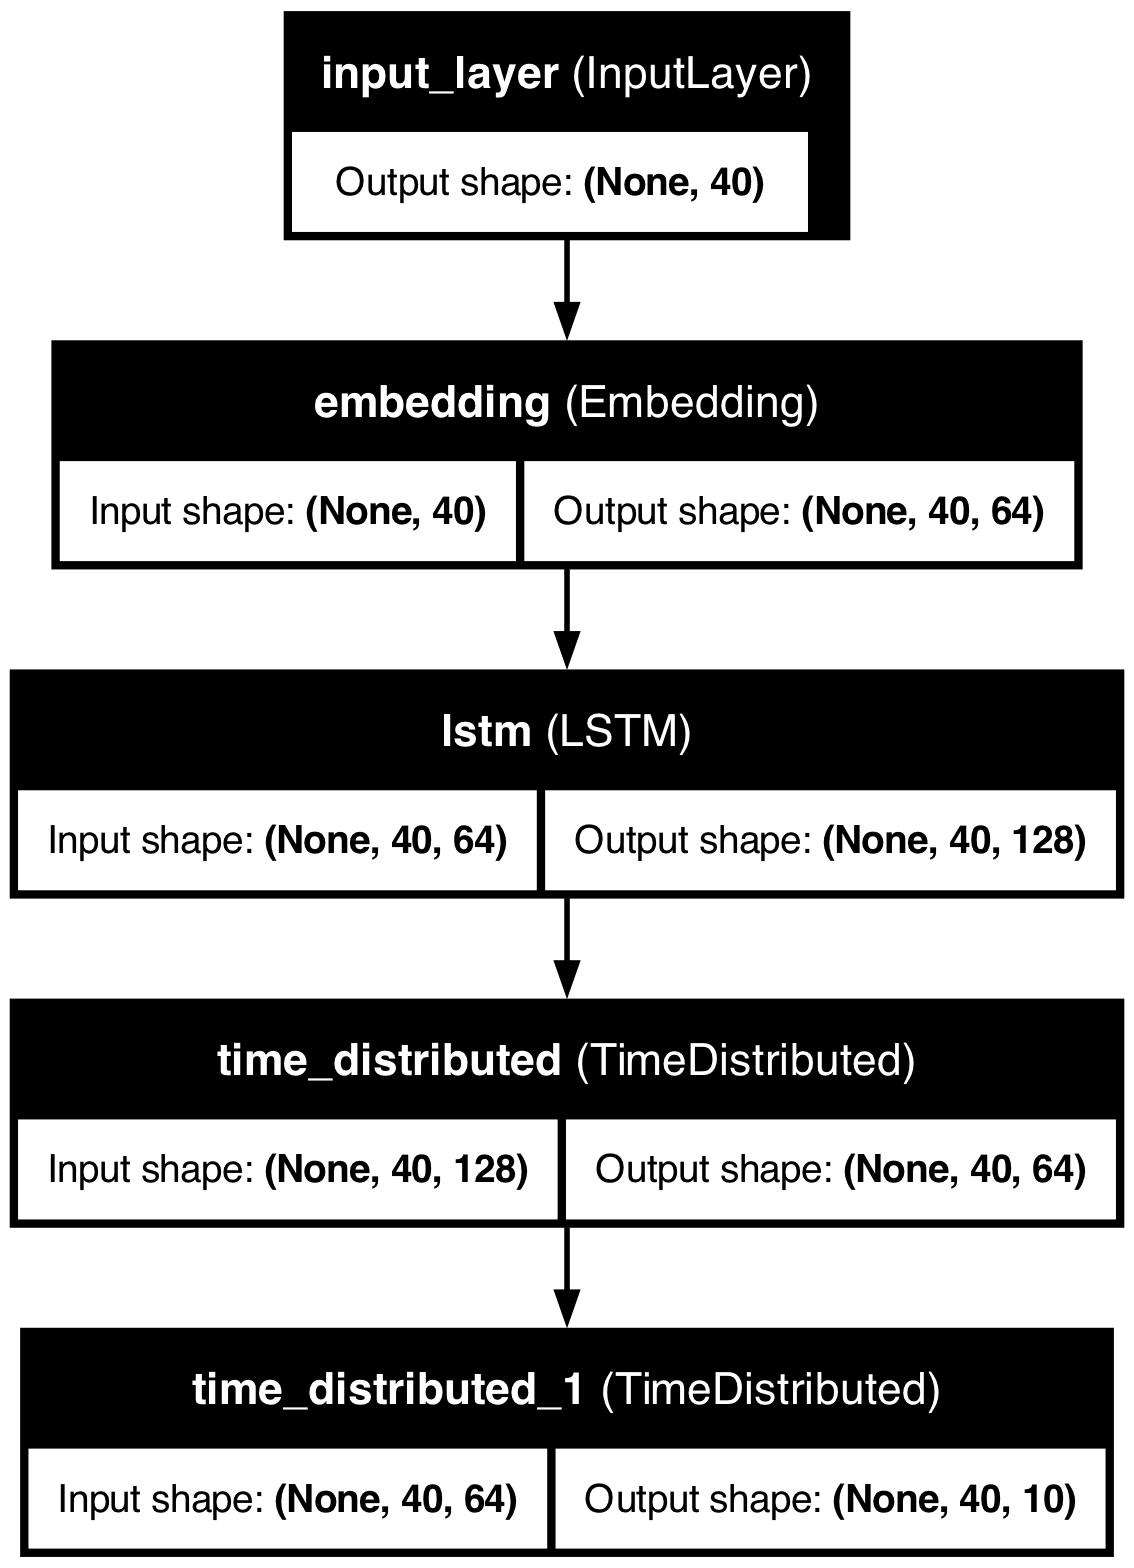

In [110]:
plot_model(model, to_file='./models/LSTM_model.png', show_shapes=True, show_layer_names=True)

### Loss, Optimizer 

In [111]:
X.shape
y.shape
X[0]

array([ 2,  3,  4,  5,  6,  7,  8,  9,  7, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 18, 23, 18, 24,  7, 25, 26, 18,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [112]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, batch_size=32, epochs=5,validation_data = (X_valid,y_valid))

Epoch 1/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.9294 - loss: 0.3736 - val_accuracy: 0.9740 - val_loss: 0.0911
Epoch 2/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9789 - loss: 0.0704 - val_accuracy: 0.9778 - val_loss: 0.0701
Epoch 3/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9844 - loss: 0.0474 - val_accuracy: 0.9785 - val_loss: 0.0674
Epoch 4/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.9860 - loss: 0.0406 - val_accuracy: 0.9784 - val_loss: 0.0695
Epoch 5/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9878 - loss: 0.0353 - val_accuracy: 0.9774 - val_loss: 0.0724


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


<Figure size 1000x1400 with 0 Axes>

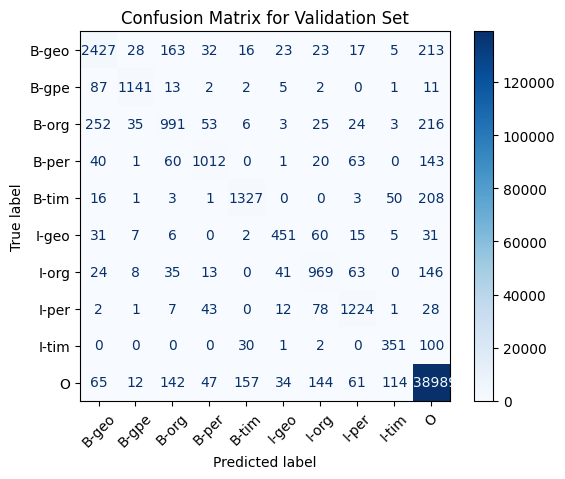

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


y_pred_valid = model.predict(X_valid)
y_pred_valid_ids = np.argmax(y_pred_valid, axis=-1)
y_valid_flat = y_valid.flatten()
y_pred_valid_flat = y_pred_valid_ids.flatten()

cm_valid = confusion_matrix(y_valid_flat, y_pred_valid_flat, labels=list(label2id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=list(label2id.keys()))
plt.figure(figsize=(10, 14))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [114]:
y_pred_valid.shape

(3808, 40, 10)

In [115]:
y_pred_valid.reshape(-1, y_pred_valid.shape[-1]).shape

(152320, 10)

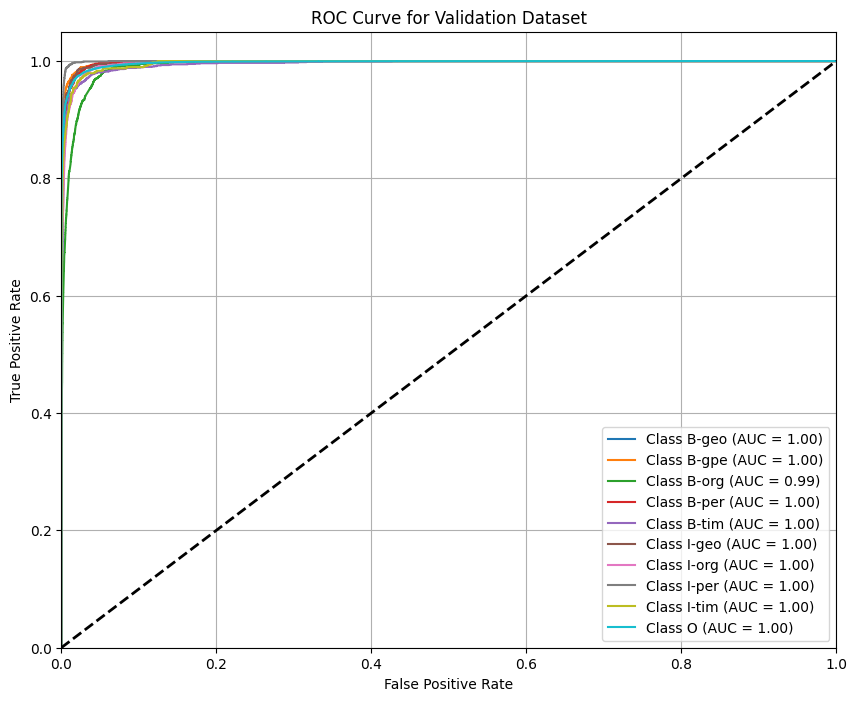

In [116]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Flatten the true labels and predicted probabilities for ROC computation
y_valid_flat = y_valid.flatten()
y_pred_valid_probs = y_pred_valid.reshape(-1, y_pred_valid.shape[-1])

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(label_size):
    fpr[i], tpr[i], _ = roc_curve((y_valid_flat == i).astype(int), y_pred_valid_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(label_size):
    plt.plot(fpr[i], tpr[i], label=f'Class {id2label[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Dataset')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [117]:
label2id

{'B-geo': 0,
 'B-gpe': 1,
 'B-org': 2,
 'B-per': 3,
 'B-tim': 4,
 'I-geo': 5,
 'I-org': 6,
 'I-per': 7,
 'I-tim': 8,
 'O': 9}

In [118]:
from seqeval.metrics import classification_report as seqeval_report

In [119]:
from sklearn.metrics import classification_report

# Predict
y_pred_test = model.predict(X_test)
y_pred_ids_test = np.argmax(y_pred_test, axis=-1)   #compare the distribution of the output of softmax for a token-word (10 scores comparison)
y_true_ids_test = y_test

# Flatten and filter padding
true_flat, pred_flat = [], []
for i in range(len(y_true_ids_test)):
    for true, pred in zip(y_true_ids_test[i], y_pred_ids_test[i]):
            true_flat.append(id2label[true])
            pred_flat.append(id2label[pred])

# Report
print(classification_report(true_flat, pred_flat, digits=4))


298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

       B-geo     0.8231    0.8306    0.8268      7491
       B-gpe     0.9244    0.9150    0.9197      3166
       B-org     0.6911    0.6053    0.6454      4006
       B-per     0.8401    0.7576    0.7967      3350
       B-tim     0.8609    0.8327    0.8466      3992
       I-geo     0.7924    0.7418    0.7663      1441
       I-org     0.7335    0.7625    0.7477      3259
       I-per     0.8306    0.8684    0.8491      3450
       I-tim     0.6806    0.7356    0.7070      1286
           O     0.9926    0.9944    0.9935    349359

    accuracy                         0.9777    380800
   macro avg     0.8169    0.8044    0.8099    380800
weighted avg     0.9773    0.9777    0.9774    380800



In [120]:
y_pred_test.shape[-1]

10

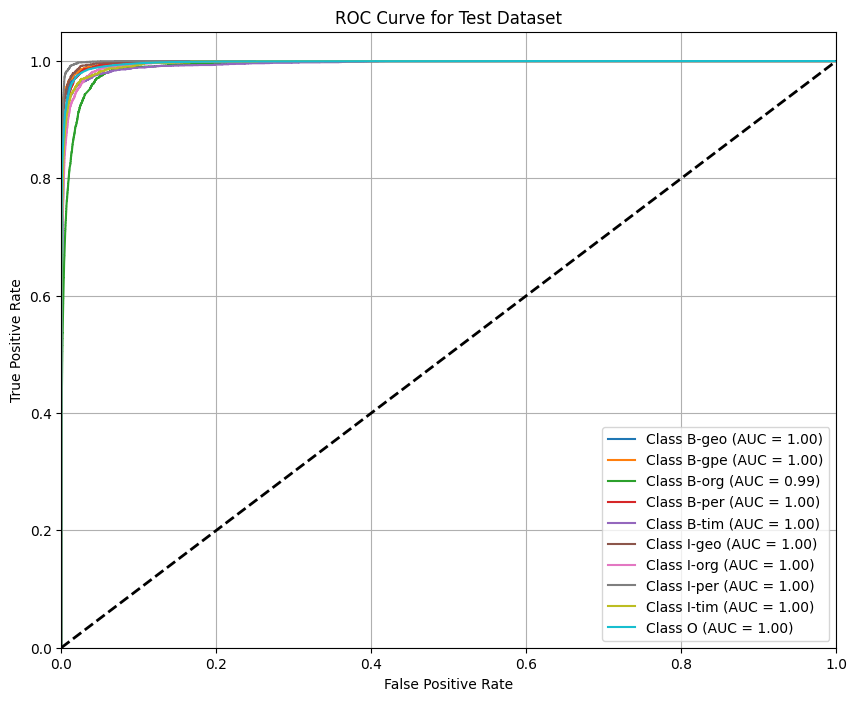

In [121]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

y_test_flat = y_test.flatten()
y_pred_test_probs = y_pred_test.reshape(-1, y_pred_test.shape[-1])

fpr = {}
tpr = {}
roc_auc = {}
for i in range(label_size):
    fpr[i], tpr[i], _ = roc_curve((y_test_flat == i).astype(int), y_pred_test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(label_size):
    plt.plot(fpr[i], tpr[i], label=f'Class {id2label[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.legend(loc='lower right')
plt.grid()
plt.show()

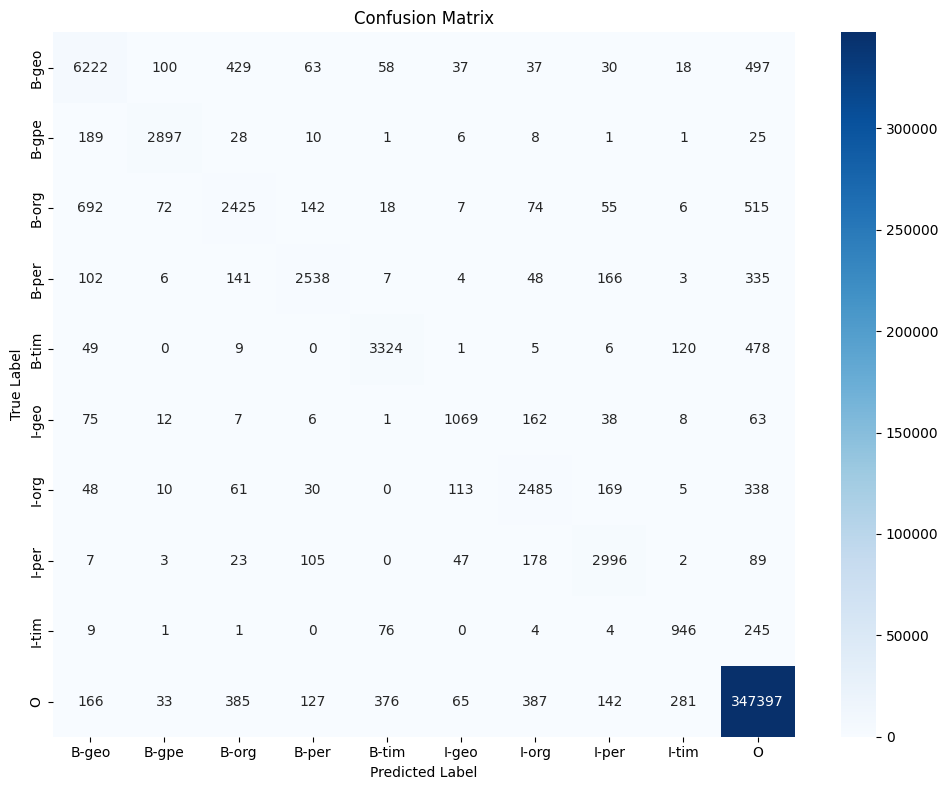

In [122]:

# Get all unique labels from your label map
all_labels = sorted(list(set(true_flat + pred_flat)))

cm = confusion_matrix(true_flat, pred_flat, labels=all_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [123]:
y_true_ids_test.shape

(9520, 40)

In [124]:
def show_predictions(df, X, y_true_ids, y_pred_ids, index=0):
    print(f"\nSentence: {' '.join(df.loc[index, 'tokens'])}")
    print(f"{'Token':15} {'True':10} {'Predicted'}")
    print("-" * 40)
    for token, true, pred in zip(df.loc[index, 'tokens'], 
                                 [id2label[i] for i in y_true_ids[index]],
                                 [id2label[i] for i in y_pred_ids[index]]):
        print(f"{token:15} {true:10} {pred}")


In [125]:
show_predictions(test_df, X_test, y_true_ids_test, y_pred_ids_test, index=22)


Sentence: Pakistani officials say unidentified gunmen have killed three people , including a former government minister , in a semi-autonomous tribal region bordering Afghanistan .
Token           True       Predicted
----------------------------------------
Pakistani       B-gpe      B-gpe
officials       O          O
say             O          O
unidentified    O          O
gunmen          O          O
have            O          O
killed          O          O
three           O          O
people          O          O
,               O          O
including       O          O
a               O          O
former          O          O
government      O          O
minister        O          O
,               O          O
in              O          O
a               O          O
semi-autonomous O          O
tribal          O          O
region          O          O
bordering       O          O
Afghanistan     B-geo      B-gpe
.               O          O


## Test

In [126]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9761 - loss: 0.0811
Test Loss: 0.0724, Accuracy: 0.9777


In [127]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('./models/ner_LSTM.keras')

In [128]:
def test_and_mask(sentence, model, word2id, label2id, id2label, MAX_LEN):
    tokens = sentence.strip().split()
    
    def encode(tokens, vocab, pad_len=MAX_LEN, fallback='<UNK>', pad_token='<PAD>'):
        fallback_id = vocab.get(fallback, list(vocab.values())[0])  
        pad_id = vocab.get(pad_token, list(vocab.values())[0])    
        ids = [vocab.get(tok, fallback_id) for tok in tokens]
        return ids[:pad_len] + [pad_id] * max(0, pad_len - len(ids))
    
    encoded_sentence = encode(tokens, word2id, pad_len=MAX_LEN)
    encoded_sentence = np.array([encoded_sentence])  
    
    # Predict using the model
    y_pred = model.predict(encoded_sentence)
    y_pred_ids = np.argmax(y_pred, axis=-1)[0] 
    
    # Decode the sentence and labels
    id2word = {v: k for k, v in word2id.items()}
    decoded_sentence = [id2word.get(word_id, '<UNK>') for word_id in encoded_sentence[0]]
    decoded_labels = [id2label[label_id] for label_id in y_pred_ids]
    
    # Mask the entities in the sentence
    masked_sentence = []
    for token, label in zip(decoded_sentence, decoded_labels):
        if token == '<PAD>':
            continue
        elif label == 'O':
            masked_sentence.append(token)
        else:
            masked_sentence.append(label)
    
    # Print the original and masked sentence
    print("Original Sentence:")
    print(" ".join(tokens))
    print("\nMasked Sentence:")
    print(" ".join(masked_sentence))

In [136]:
# Example usage
random_sentence = "On June 15, 2023, Dr. Emily Carter, a renowned physicist from Princeton University, gave a keynote speech at the Global Climate Summit in Geneva, Switzerland. She emphasized the urgent need for international collaboration "
test_and_mask(random_sentence, model, word2id, label2id, id2label, MAX_LEN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Original Sentence:
On June 15, 2023, Dr. Emily Carter, a renowned physicist from Princeton University, gave a keynote speech at the Global Climate Summit in Geneva, Switzerland. She emphasized the urgent need for international collaboration

Masked Sentence:
On B-tim I-tim I-tim B-per I-per I-per a renowned <UNK> from <UNK> I-tim gave a keynote speech at the Global Climate Summit in B-tim I-tim She emphasized the urgent need for international collaboration


In [130]:
# Example usage
random_sentence = "On June 15, 2023, Dr. Emily Carter, a renowned physicist from Princeton University, gave a keynote speech at the Global Climate Summit in Geneva, Switzerland. She emphasized the urgent need for international collaboration to combat climate change. Representatives from over 50 countries, including Canada, Brazil, and India, attended the event. Microsoft and Tesla announced a joint venture to develop carbon-neutral technologies. Meanwhile, UN Secretary-General António Guterres praised the summit's progress in aligning with the Paris Agreement. The summit also featured contributions from scientists at MIT and Oxford University. Elon Musk participated virtually from California, showcasing Tesla’s latest solar innovations. A follow-up summit is scheduled for November 2024 in Tokyo, Japan. Attendees shared insights via the official Twitter hashtag #GCS2023. The event concluded with a ceremonial tree planting sponsored by Green Earth Foundation."

In [131]:
batches = []
i = 1
MAX_LEN = len(random_sentence)
for i in range(0,MAX_LEN,40):
    chunk = random_sentence[i:40+i]
    string = ' '.join(chunk)
    batches.append(string)
    

In [135]:
masked_sentence_ = []
for sentence in batches:
    original_sequence,masked_sentence = test_and_mask(sentence, model,word2id, label2id,id2label,40)
    masked_sentence = ' '.join(masked_sentence)
    masked_sentence_.append(masked_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Original Sentence:
O n J u n e 1 5 , 2 0 2 3 , D r . E m i l y C a r t e r , a r e

Masked Sentence:
B-geo <UNK> <UNK> I-org I-org I-org 1 I-tim , 2 I-tim 2 I-tim , D <UNK> . <UNK> <UNK> <UNK> l <UNK> C a <UNK> I-org I-org I-org , a <UNK> <UNK>


TypeError: cannot unpack non-iterable NoneType object

In [244]:
random_sentence

['On',
 'June',
 '15,',
 '2023,',
 'Dr.',
 'Emily',
 'Carter,',
 'a',
 'renowned',
 'physicist',
 'from',
 'Princeton',
 'University,',
 'gave',
 'a',
 'keynote',
 'speech',
 'at',
 'the',
 'Global',
 'Climate',
 'Summit',
 'in',
 'Geneva,',
 'Switzerland.',
 'She',
 'emphasized',
 'the',
 'urgent',
 'need',
 'for',
 'international',
 'collaboration',
 'to',
 'combat',
 'climate',
 'change.',
 'Representatives',
 'from',
 'over',
 '50',
 'countries,',
 'including',
 'Canada,',
 'Brazil,',
 'and',
 'India,',
 'attended',
 'the',
 'event.',
 'Microsoft',
 'and',
 'Tesla',
 'announced',
 'a',
 'joint',
 'venture',
 'to',
 'develop',
 'carbon-neutral',
 'technologies.',
 'Meanwhile,',
 'UN',
 'Secretary-General',
 'António',
 'Guterres',
 'praised',
 'the',
 "summit's",
 'progress',
 'in',
 'aligning',
 'with',
 'the',
 'Paris',
 'Agreement.',
 'The',
 'summit',
 'also',
 'featured',
 'contributions',
 'from',
 'scientists',
 'at',
 'MIT',
 'and',
 'Oxford',
 'University.',
 'Elon',
 'Musk